In [1]:
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt

In [2]:
#Constants
R_Earth = 6378000 #m
G = 6.67e-11
M_Earth = 6e24
k = 1.38e-23
h = 6.63e-34
c = 3e8


In [3]:
#Functions

def bandwidth(nu,R):
    return nu/R

def orbit_vels(orbit_height):
    v = np.sqrt(G*M_Earth/(R_Earth + orbit_height))
    vGround = (R_Earth*v)/(R_Earth + orbit_height)
    return v, vGround


def footprint_crosstrack(aperture,nu,orbit_height):
    wlength = 3e8 / (nu)
    theta = np.arcsin(1.22*wlength/aperture)
    footprint = 2 * orbit_height * np.tan(theta/2)
    return footprint

def footprint_connicaltrack(aperture,nu,orbit_height,offset_theta): 
    wlength = 3e8 / (nu)
    theta = np.arcsin(1.22*wlength/aperture)
    footprint = 2 * (orbit_height/np.cos(offset_theta)) * np.tan(theta/2)
    return footprint

def int_time(footprint,sample_overlap,vGround,swath,cal_targets): 
    Nsamples = swath/(footprint*sample_overlap)
    trotate = footprint*sample_overlap / vGround
    SampleRate = Nsamples + cal_targets / trotate
    int_time = 1/SampleRate
    return int_time

def B(nu,T):
    return ( (2 * h * nu**3) / c**2 ) * (1/ (np.exp( (h*nu) / (k * T)) - 1))

def Aomega1(nu): #Wavelength squared
    wlength = 3e8 / (nu)
    Aomega1 = wlength**2 
    return Aomega1

def Aomega2(footprint,orbit_height,aperture): #geometric throughput
    Asource = np.pi * (footprint / 2)**2
    omega = (np.pi * (aperture/2)**2 ) / orbit_height**2
    return Asource * omega

def Pb(nu,T,OptEff,Aomega):
    return B(nu,T) * OptEff * Aomega

def Pback(nu,dnu,T,OptEff,Aomega):
    flower = nu - dnu/2
    fhigher = nu + dnu/2
    Pback = np.zeros(len(nu))
    Pbackerr = np.zeros(len(nu))
    for i in range(len(nu)):
        Pback[i],Pbackerr[i] = quad(Pb,flower[i], fhigher[i],args=(T,OptEff,Aomega[i]))
    return Pback

def NEPph(Pback,nu):
    return 2 * np.sqrt(Pback * h * nu)

def NEPradio(dnu,T):
    return (2*dnu)**0.5 * k * T

def Pmin_shot(NEPph,int_time):
    return NEPph / ((2*int_time)**0.5)

def Pmin_rad(dnu,T,int_time):
    return (k**2 * T**2 * dnu)**0.5 / (int_time**0.5)

def num_MRT(T,nu,dnu,OptEff,Aomega,Pmin): 
    BackT = np.linspace(T-2,T+2,10000)
    BackP = np.zeros((len(nu),len(BackT)))
    BackPerr = np.zeros((len(nu),len(BackT)))
    flower = nu - dnu/2
    fhigher = nu + dnu/2
    
    #Loop through every T and nu and find background power
    for j in range(len(BackT)):
        for i in range(len(nu)):
            BackP[i,j],BackPerr[i,j] = quad(Pb,flower[i], fhigher[i],args=(BackT[j],OptEff,Aomega[i]))
    
    dP = np.zeros((len(nu),len(BackT)))
    
    #Find what change in T is equivalent to the minimum power for every nu.
    for i in range(len(nu)):
        for j in range(len(BackT)):
            if (BackP[i,j]-BackP[i,0])> Pmin[i]:
                dP[i,j] = BackT[j] - BackT[0]
                
    MRTnum = np.zeros(len(nu))
    for i in range(len(nu)):
        a = dP[i,:]
        b = a[a>0]
        MRTnum[i] = min(b)
    
    return MRTnum

def MRTwav(T,int_time,dnu):
    return T / (int_time*dnu)**0.5

def num_NEdT_shot(NEPph,T,nu,dnu,OptEff,Aomega):
    Pmin = Pmin_shot(NEPph,0.5) #set int_time to 0.5s
    MRT = num_MRT(T,nu,dnu,OptEff,Aomega,Pmin)
    return MRT

def num_NEdT_wav(T,nu,dnu,OptEff,Aomega):
    Pmin = Pmin_rad(dnu,T,0.5) #set int_time to 0.5s
    MRT = num_MRT(T,nu,dnu,OptEff,Aomega,Pmin)
    return MRT
    

# MWS values

In [4]:
#MWS input values
nuMWS = np.array([23.8,31.4,50.3,52.8,53.246,53.326,53.166,53.596,53.711,53.481,53.948,54.029,53.867,54.4,54.94,55.5,57.290344,57.290344,57.507344,57.073344,57.290344,57.612544,56.968144,57.338344,57.242344,57.660544,57.564544,57.016144,56.920144,57.312344,57.268344,57.634544,57.590544,56.990144,56.946144,57.300344,57.280344,57.622544,57.602544,56.978144,56.958144,57.294844,57.285844,57.617044,57.608044,56.972644,56.963644,89,165.5,166.225,164.775,183.311,190.311,176.311,187.811,178.811,186.311,180.311,185.111,181.511,184.311,182.311,229])
nu_MWS = nuMWS*1e9 #change to Hz

dnuMWS = np.array([270,180,180,400,140,140,140,170,170,170,142,142,142,400,400,330,330,78,78,78,36,36,36,36,36,36,36,36,36,16,16,16,16,16,16,8,8,8,8,8,8,3,3,3,3,3,3,4000,1350,1350,1350,2000,2000,2000,2000,2000,1000,1000,1000,1000,500,500,2000])
dnu_MWS = dnuMWS*1e6 #change to Hz

footprint_MWS_stated = np.array([40,40,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17])

NEdTactual_MWS = np.array([0.25,0.35,0.5,0.35,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.4,0.35,0.35,0.4,0.4,0.55,0.55,0.55,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.6,0.9,0.9,0.9,0.9,0.9,0.9,1.2,1.2,1.2,1.2,1.2,1.2,2,2,2,2,2,2,0.25,0.5,0.5,0.5,0.4,0.4,0.4,0.4,0.4,0.6,0.6,0.6,0.6,0.75,0.75,0.7])

orbit_h_MWS = 830000 #m

swath_MWs = 2100000 #m

ap_MWS = 0.35 #m

int_time_MWS = 1.3 / 95  #95 samples occur over 1.3 seconds

Tback_MWS = 280 #K  

Opt_Eff = 0.5 #Assumed optical efficiency


In [5]:
#MWS outputs

foorprint_MWS = footprint_crosstrack(ap_MWS,nu_MWS,orbit_h_MWS) 

Aomega_MWS = Aomega1(nu_MWS) #Chose aomega 1 as was shown to be more accurate
Pback_MWS = Pback(nu_MWS,dnu_MWS,Tback_MWS,Opt_Eff,Aomega_MWS)

NEPph_MWS = NEPph(Pback_MWS,nu_MWS)

NEPradio_MWS = NEPradio(dnu_MWS,Tback_MWS)

Pmin_shot_MWS = Pmin_shot(NEPph_MWS,int_time_MWS)

Pmin_rad_MWS = Pmin_rad(dnu_MWS,Tback_MWS,int_time_MWS)

MRTwav_MWS = MRTwav(Tback_MWS,int_time_MWS,dnu_MWS)

NEdTwav_MWS = MRTwav(Tback_MWS,0.5,dnu_MWS) #Set int_time to 0.5s to find NEdT

In [6]:
#Seperated due to taking time to complete
num_MRT_MWS = num_MRT(Tback_MWS,nu_MWS,dnu_MWS,Opt_Eff,Aomega_MWS,Pmin_rad_MWS)

In [7]:
num_NEdT_shot_MWS = num_NEdT_shot(NEPph_MWS,Tback_MWS,nu_MWS,dnu_MWS,Opt_Eff,Aomega_MWS)

In [8]:
num_NEdT_wav_MWS = num_NEdT_wav(Tback_MWS,nu_MWS,dnu_MWS,Opt_Eff,Aomega_MWS)

Text(0, 0.5, 'Minimum resolvable temperature (K)')

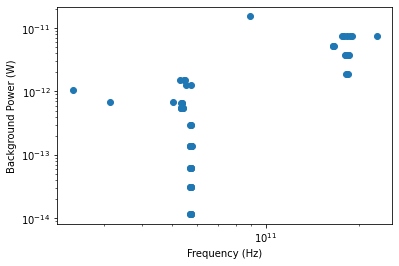

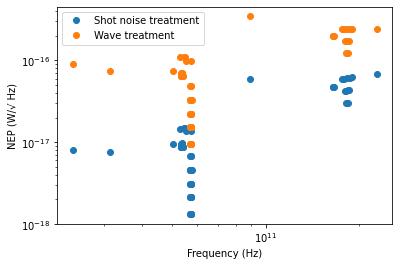

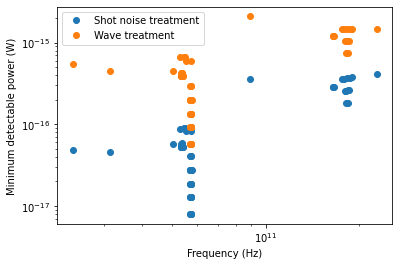

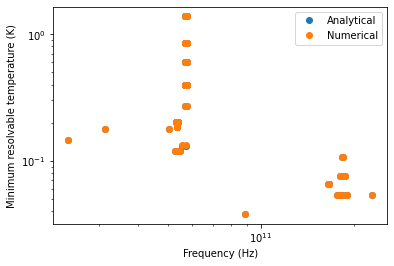

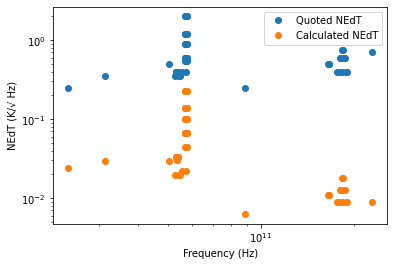

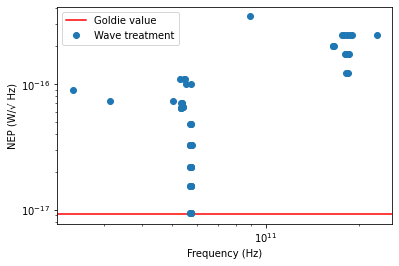

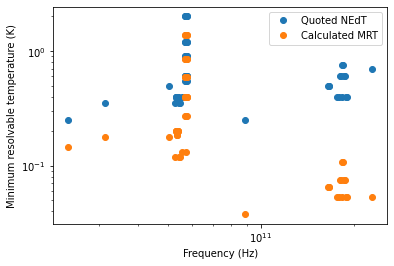

In [9]:
#Plot Results
plt.figure()
plt.loglog(nu_MWS,Pback_MWS,linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Background Power (W)')

plt.figure()
plt.loglog(nu_MWS,NEPph_MWS,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_MWS,NEPradio_MWS,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')

plt.figure()
plt.loglog(nu_MWS,Pmin_shot_MWS,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_MWS,Pmin_rad_MWS,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum detectable power (W)')

plt.figure()
plt.loglog(nu_MWS,MRTwav_MWS,label='Analytical',linestyle='none',marker='o')
plt.loglog(nu_MWS,num_MRT_MWS,label='Numerical',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')


plt.figure()
plt.loglog(nu_MWS,NEdTactual_MWS,label='Quoted NEdT',linestyle='none',marker='o')
plt.loglog(nu_MWS,NEdTwav_MWS,label='Calculated NEdT',linestyle='none',marker='o')
#plt.loglog(nu_MWS,num_NEdT_shot_MWS,label='NEdT numerical - shot noise',linestyle='none',marker='o')
#plt.loglog(nu_MWS,num_NEdT_wav_MWS,label='Numerical',linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEdT (K/\u221A Hz)')
plt.legend(loc='best')

plt.figure()
plt.axhline(y=9.2e-18,label='Goldie value',color='r',linestyle='-')
plt.loglog(nu_MWS,NEPradio_MWS,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')




plt.figure()
plt.loglog(nu_MWS,NEdTactual_MWS,label='Quoted NEdT',linestyle='none',marker='o')
plt.loglog(nu_MWS,MRTwav_MWS,label='Calculated MRT',linestyle='none',marker='o')
#plt.loglog(nu_MWS,num_MRT_MWS,label='Numerical',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')

In [10]:
#difference in analytical and numerical method
print(np.mean(MRTwav_MWS-num_MRT_MWS))
#print(MRTwav_MWS-num_MRT_MWS)
print(np.mean(MRTwav_MWS/num_MRT_MWS *100))

#min and max MRT
print(np.min(MRTwav_MWS),np.min(num_MRT_MWS))
print(np.max(MRTwav_MWS),np.max(num_MRT_MWS))

print(nu_MWS[np.argmax(MRTwav_MWS)])
print(nu_MWS[np.argmin(MRTwav_MWS)])

#Diff between  MWS NEdT and calculated NEdT
print(np.max(NEdTactual_MWS/NEdTwav_MWS * 100))
print(np.min(NEdTactual_MWS/NEdTwav_MWS * 100))
print(np.mean(NEdTactual_MWS/NEdTwav_MWS * 100))

print(np.max(NEdTactual_MWS/MRTwav_MWS * 100))
print(np.min(NEdTactual_MWS/MRTwav_MWS * 100))
print(np.mean(NEdTactual_MWS/MRTwav_MWS * 100))

#Compare min NEP to Goldie value
print(np.min(NEPradio_MWS)) #still above 9.2e-18 limit from Goldie

print(np.mean(NEdTwav_MWS/num_NEdT_wav_MWS *100))

-0.00019429471561409944
99.88752849666882
0.0378458411494274 0.038003800380010944
1.3819347270199087 1.3821382138214062
57294844000.0
89000000000.0
7905.694150420948
857.1428571428571
2028.3978035013563
1307.8709094514923
141.8006043203162
335.5660400615767
9.4648283661142e-18
99.15036156703329


# MWI values


In [11]:
#MWI inputs
nuMWI = np.array([18.7,23.8,31.4,50.3,52.61,53.24,53.75,89,118.7503,121.9503,115.5503,120.8503,116.6503,120.1503,117.3503,119.9503,117.5503,165.5,166.25,164.75,183.31,190.31,176.31,189.41,177.21,188.21,178.41,186.71,179.91,185.31,181.31])
nu_MWI = nuMWI * 1e9

dnuMWI = np.array([200,400,200,400,400,400,400,4000,500,500,500,400,400,400,400,400,400,1350,1350,1350,2000,2000,2000,1500,1500,1500,1500,1500,1500,1500,1500])
dnu_MWI = dnuMWI * 1e6

NEdTactual_MWI = np.array([0.8,0.7,0.9,1.1,1.1,1.1,1.1,1.1,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.2,1.3,1.3])

orbit_h_MWI = 830000 #m

offset = np.deg2rad(44.82)

swath_MWI = 1700000 #m

calT = 2 #one hot, one cold calibration targets

ap_MWI = 0.75 #m

#No integration time given in science plan, will calculate from footprints

Tback_MWI = 280 #K  

Opt_Eff = 0.5 #Assumed optical efficiency

In [12]:
#MWI outputs

foorprint_MWI = footprint_connicaltrack(ap_MWI,nu_MWI,orbit_h_MWI,offset) 

Aomega_MWI = Aomega1(nu_MWI) 

vMWI, vMWIground = orbit_vels(orbit_h_MWI)

int_time_MWI = int_time(foorprint_MWI,0.9,vMWIground,swath_MWI,calT)  #Calculates inttime for each footprint
int_time_MWI = np.min(int_time_MWI) # Take the smallest int time and set for all observations

Pback_MWI = Pback(nu_MWI,dnu_MWI,Tback_MWI,Opt_Eff,Aomega_MWI)

NEPph_MWI = NEPph(Pback_MWI,nu_MWI)

NEPradio_MWI = NEPradio(dnu_MWI,Tback_MWI)

Pmin_shot_MWI = Pmin_shot(NEPph_MWI,int_time_MWI)

Pmin_rad_MWI = Pmin_rad(dnu_MWI,Tback_MWI,int_time_MWI)

MRTwav_MWI = MRTwav(Tback_MWI,int_time_MWI,dnu_MWI)

NEdTwav_MWI = MRTwav(Tback_MWI,0.5,dnu_MWI) #Set int_time to 0.5s to find NEdT

In [13]:
num_MRT_MWI = num_MRT(Tback_MWI,nu_MWI,dnu_MWI,Opt_Eff,Aomega_MWI,Pmin_rad_MWI)


In [14]:
num_NEdT_wav_MWI = num_NEdT_wav(Tback_MWI,nu_MWI,dnu_MWI,Opt_Eff,Aomega_MWI)

Text(0, 0.5, 'NEP (W/√ Hz)')

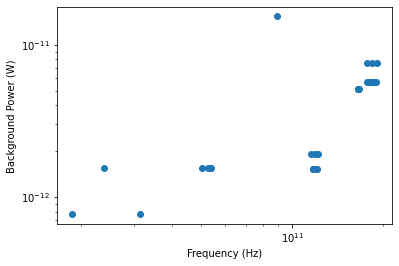

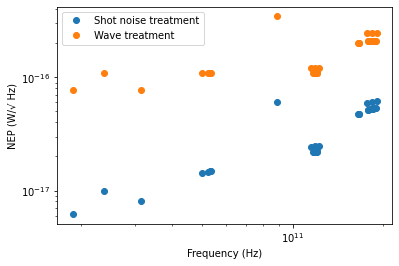

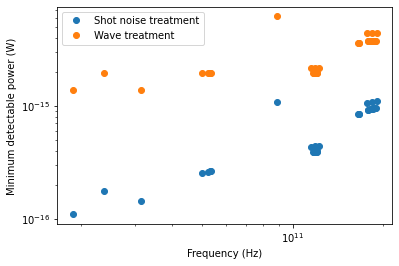

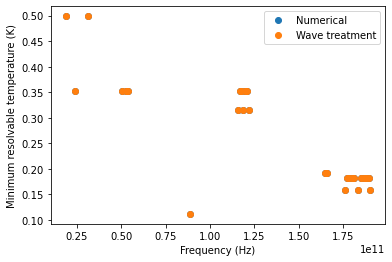

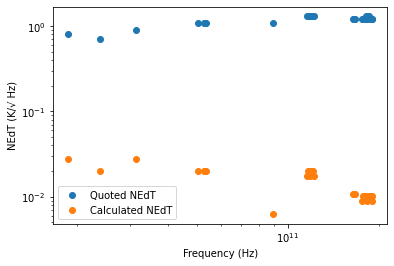

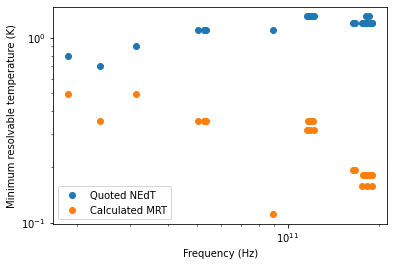

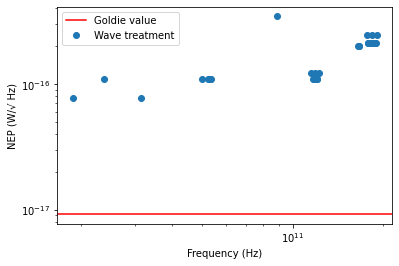

In [15]:
#Plot Results
plt.figure()
plt.loglog(nu_MWI,Pback_MWI,linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Background Power (W)')

plt.figure()
plt.loglog(nu_MWI,NEPph_MWI,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEPradio_MWI,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')

plt.figure()
plt.loglog(nu_MWI,Pmin_shot_MWI,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_MWI,Pmin_rad_MWI,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum detectable power (W)')

plt.figure()
plt.plot(nu_MWI,num_MRT_MWI,label='Numerical',linestyle='none',marker='o')
plt.plot(nu_MWI,MRTwav_MWI,label='Wave treatment',linestyle='none',marker='o')
#plt.loglog(nu_MWI,NEdTwav_MWI,label='NEdT',linestyle='none',marker='o')
plt.legend()
#plt.ylim(0.5,0.6)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')

plt.figure()
plt.loglog(nu_MWI,NEdTactual_MWI,label='Quoted NEdT',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEdTwav_MWI,label='Calculated NEdT',linestyle='none',marker='o')
#plt.loglog(nu_MWI,num_NEdT_wav_MWI,label='Numerical',linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEdT (K/\u221A Hz)')
plt.legend()

plt.figure()
plt.loglog(nu_MWI,NEdTactual_MWI,label='Quoted NEdT',linestyle='none',marker='o')
#plt.loglog(nu_MWI,num_MRT_MWI,label='Numerical',linestyle='none',marker='o')
plt.loglog(nu_MWI,MRTwav_MWI,label='Calculated MRT',linestyle='none',marker='o')
#plt.loglog(nu_MWI,NEdTwav_MWI,label='NEdT',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')

plt.figure()
plt.axhline(y=9.2e-18,label='Goldie value',color='r',linestyle='-')
plt.loglog(nu_MWI,NEPradio_MWI,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')

In [16]:
#difference in analytical and numerical method
print(np.mean(MRTwav_MWI-num_MRT_MWI))
print(np.mean(MRTwav_MWI/num_MRT_MWI *100))


#Diff between  MWS NEdT and calculated NEdT
print(np.max(NEdTactual_MWI/NEdTwav_MWI * 100))
print(np.mean(NEdTactual_MWI/NEdTwav_MWI * 100))

#Compare min NEP to Goldie value
print(np.min(NEPradio_MWI)) #still above 9.2e-18 limit from Goldie

print(np.mean(MRTwav_MWI/num_MRT_MWI *100))

print(np.max(NEdTactual_MWI/MRTwav_MWI * 100))
print(np.min(NEdTactual_MWI/MRTwav_MWI * 100))
print(np.mean(NEdTactual_MWI/MRTwav_MWI * 100))

#Average resolution
print(np.mean(nu_MWI/dnu_MWI))

-0.00023239321247129244
99.89771372971596
17569.105537498348
9055.855437519822
7.728000000000001e-17
99.89771372971596
986.4601283169059
160.42122938252848
508.46301183908463
160.35975519713259


# ICI values

In [17]:
np.mean(nu_MWI/dnu_MWI) #MWI responsivity - can use to estimate dnu for ICI as is not given

160.35975519713259

In [18]:
nuICI = np.array([183.31,190.31,176.31,186.71,179.91,185.31,181.31,243.2,245.7,240.7,325.15,334.65,315.65,328.65,321.65,326.65,317.65,448,455.2,440.8,451,445,449.4,446.6,664,668.2,659.8])
nu_ICI = nuICI * 1e9

#No given dnu - can estimate

NEdTactual_ICI = np.array([0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.7,0.7,0.7,1.2,1.2,1.2,1.3,1.3,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5,1.5])

orbit_h_ICI = 830000 #m

offset = np.deg2rad(44.82)

swath_ICI = 1700000 #m

calT = 2 #one hot, one cold calibration targets

ap_ICI = 0.75 #m

#No integration time given in science plan, will calculate from footprints

Tback_ICI = 280 #K  

Opt_Eff = 0.5 #Assumed optical efficiency

In [19]:
#ICI outputs

dnu_ICI = bandwidth(nu_ICI,np.mean(nu_MWI/dnu_MWI))

foorprint_ICI = footprint_connicaltrack(ap_ICI,nu_ICI,orbit_h_ICI,offset) 

Aomega_ICI = Aomega1(nu_ICI) 

vICI, vICIground = orbit_vels(orbit_h_ICI)

int_time_ICI = int_time(foorprint_ICI,0.9,vICIground,swath_ICI,calT) 
int_time_ICI = np.min(int_time_ICI) # Take the smallest int time and set for all observations

Pback_ICI = Pback(nu_ICI,dnu_ICI,Tback_ICI,Opt_Eff,Aomega_ICI)

NEPph_ICI = NEPph(Pback_ICI,nu_ICI)

NEPradio_ICI = NEPradio(dnu_ICI,Tback_ICI)

Pmin_shot_ICI = Pmin_shot(NEPph_ICI,int_time_ICI)

Pmin_rad_ICI = Pmin_rad(dnu_ICI,Tback_ICI,int_time_ICI)

MRTwav_ICI = MRTwav(Tback_ICI,int_time_ICI,dnu_ICI)

NEdTwav_ICI = MRTwav(Tback_ICI,0.5,dnu_ICI) #Set int_time to 0.5s to find NEdT

In [20]:
num_MRT_ICI = num_MRT(Tback_MWI,nu_ICI,dnu_ICI,Opt_Eff,Aomega_ICI,Pmin_rad_ICI)


In [21]:
num_NEdT_wav_ICI = num_NEdT_wav(Tback_ICI,nu_ICI,dnu_ICI,Opt_Eff,Aomega_ICI)

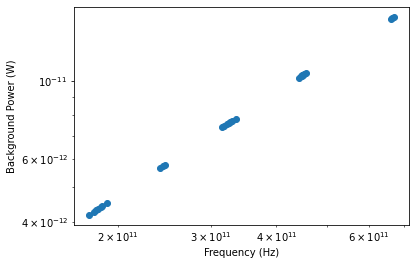

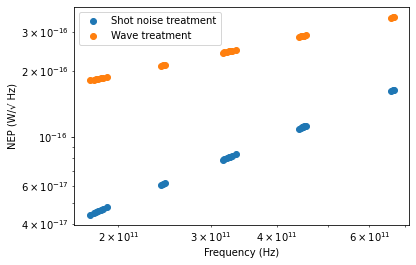

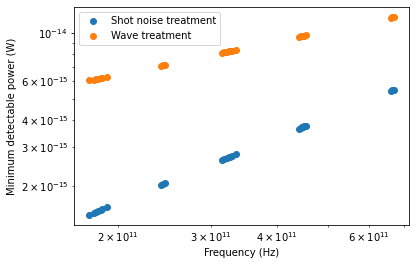

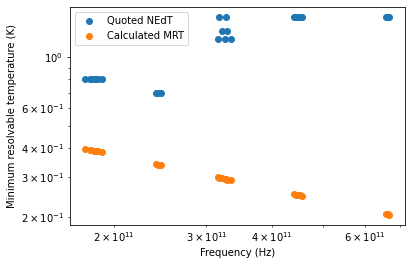

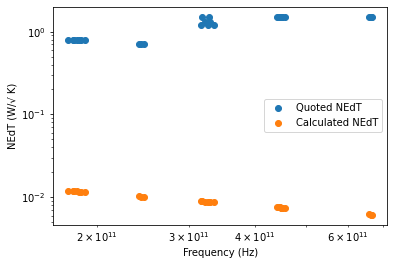

In [22]:
#Plot Results
plt.figure()
plt.loglog(nu_ICI,Pback_ICI,linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Background Power (W)')

plt.figure()
plt.loglog(nu_ICI,NEPph_ICI,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEPradio_ICI,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')

plt.figure()
plt.loglog(nu_ICI,Pmin_shot_ICI,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_ICI,Pmin_rad_ICI,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum detectable power (W)')

plt.figure()
#plt.plot(nu_ICI,num_MRT_ICI,label='Numerical',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTactual_ICI,label='Quoted NEdT',linestyle='none',marker='o')
plt.plot(nu_ICI,MRTwav_ICI,label='Calculated MRT',linestyle='none',marker='o')
#plt.loglog(nu_MWI,NEdTwav_MWI,label='NEdT',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')

plt.figure()
plt.loglog(nu_ICI,NEdTactual_ICI,label='Quoted NEdT',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTwav_ICI,label='Calculated NEdT',linestyle='none',marker='o')
#plt.loglog(nu_ICI,num_NEdT_wav_ICI,label='Numerical',linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEdT (W/\u221A K)')
plt.legend()

In [23]:
#difference in analytical and numerical method
print(np.mean(MRTwav_ICI-num_MRT_ICI))
print(np.mean(MRTwav_ICI/num_MRT_ICI *100))


#Diff between  MWS NEdT and calculated NEdT
print(np.max(NEdTactual_ICI/NEdTwav_ICI * 100))
print(np.mean(NEdTactual_ICI/NEdTwav_ICI * 100))
print(np.mean(NEdTactual_ICI/NEdTwav_ICI ))

#Compare min NEP to Goldie value
print(np.min(NEPradio_ICI)) #still above 9.2e-18 limit from Goldie

print(np.max(NEdTactual_ICI/MRTwav_ICI * 100))
print(np.min(NEdTactual_ICI/MRTwav_ICI * 100))
print(np.mean(NEdTactual_ICI/MRTwav_ICI * 100))

-0.0003031604651974689
99.89132604938287
24452.528470597917
14303.712309923792
143.0371230992379
1.8119361762575718e-16
732.7079416547015
200.73119209825614
428.60367659839835


In [24]:
print(int_time_MWS,int_time_MWI,int_time_ICI) #Big differences in int time

0.01368421052631579 0.0015762669637418613 0.000448935816752654


# MWS, MWI, ICI combined

In [25]:
#inputs

nu_com = np.append(nu_MWS,nu_MWI) 
nu_com = np.append(nu_com,nu_ICI)
nu_com = np.unique(nu_com)

#dnu_com = np.array([bandwidth(nu_com,500),bandwidth(nu_com,1000)])
dnu_com = bandwidth(nu_com,500) 

Tback_com = 280 #K  

calT_com = 2

Opt_Eff = 0.5 #Assumed optical efficiency

## Cross track scanning method

In [26]:
NEdT_actual_com = np.append(NEdTactual_MWS,NEdTactual_MWI)
NEdT_actual_com = np.append(NEdT_actual_com,NEdTactual_ICI)

nucom = np.append(nu_MWS,nu_MWI) 
nucom = np.append(nucom,nu_ICI)


In [27]:
orbit_h_com_cross = 830000 #m

swath_com_cross = 2100000 #m

ap_com_cross = 0.35 #m

#functions
foorprint_com_cross = footprint_crosstrack(ap_com_cross,nu_com,orbit_h_com_cross) 

Aomega_com_cross = Aomega1(nu_com) 

vcom_cross, vcomground_cross = orbit_vels(orbit_h_com_cross)

int_time_com_cross = int_time(foorprint_com_cross,0.9,vcomground_cross,swath_com_cross,calT_com)  
int_time_com_cross = np.min(int_time_com_cross) # Take the smallest int time and set for all observations

Pback_com_cross = Pback(nu_com,dnu_com,Tback_com,Opt_Eff,Aomega_com_cross)

NEPph_com_cross = NEPph(Pback_com_cross,nu_com)

NEPradio_com_cross = NEPradio(dnu_com,Tback_com)

Pmin_shot_com_cross = Pmin_shot(NEPph_com_cross,int_time_com_cross)

Pmin_rad_com_cross = Pmin_rad(dnu_com,Tback_com,int_time_com_cross)

MRTwav_com_cross = MRTwav(Tback_com,int_time_com_cross,dnu_com)

NEdTwav_com_cross = MRTwav(Tback_com,0.5,dnu_com)


In [28]:
int_time_com_cross

0.0005532094644386021

In [29]:
num_MRT_com_cross = num_MRT(Tback_com,nu_com,dnu_com,Opt_Eff,Aomega_com_cross,Pmin_rad_com_cross)

In [30]:
num_NEdT_wav_com_cross = num_NEdT_wav(Tback_com,nu_com,dnu_com,Opt_Eff,Aomega_com_cross)

Text(0, 0.5, 'Minimum resolvable temperature (K)')

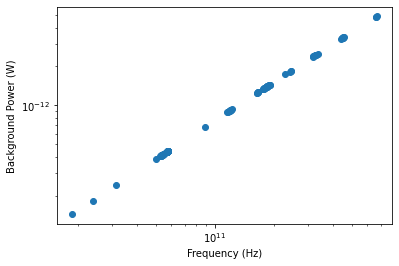

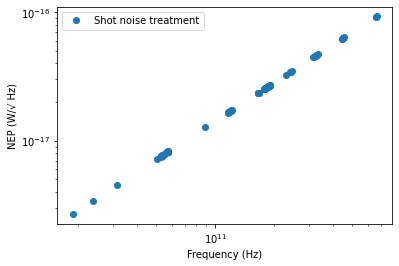

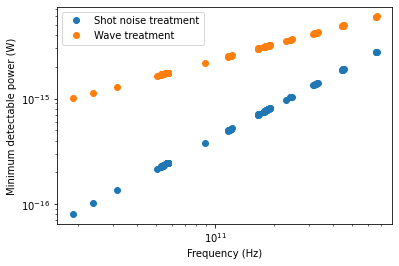

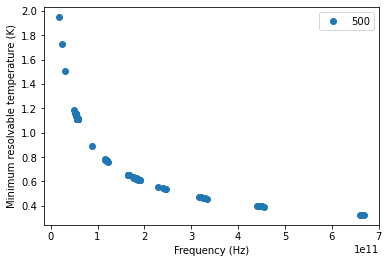

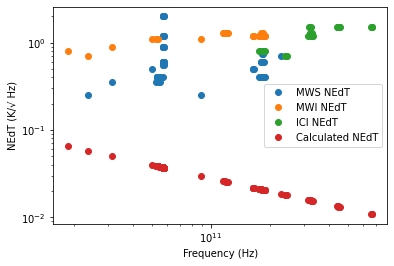

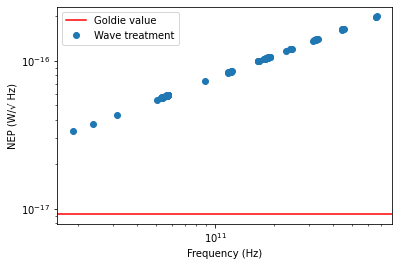

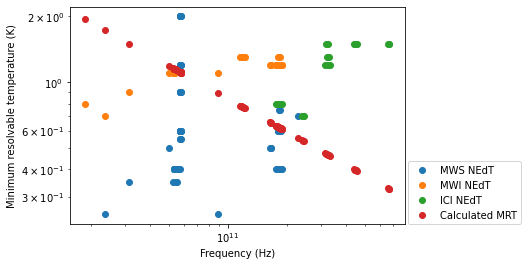

In [31]:
#Plot Results
plt.figure()
plt.loglog(nu_com,Pback_com_cross,linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Background Power (W)')

plt.figure()
plt.loglog(nu_com,NEPph_com_cross,label='Shot noise treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')

plt.figure()
plt.loglog(nu_com,Pmin_shot_com_cross,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_com,Pmin_rad_com_cross,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum detectable power (W)')

plt.figure()
plt.plot(nu_com,MRTwav_com_cross,label='500',linestyle='none',marker='o')
#plt.plot(nu_com,num_MRT_com_cross,label='Numerical',linestyle='none',marker='o')
plt.legend()
#plt.ylim(0.44,0.54)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')


plt.figure()
plt.loglog(nu_MWS,NEdTactual_MWS,label='MWS NEdT',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEdTactual_MWI,label='MWI NEdT',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTactual_ICI,label='ICI NEdT',linestyle='none',marker='o')
plt.loglog(nu_com,NEdTwav_com_cross,label='Calculated NEdT',linestyle='none',marker='o')
#plt.loglog(nu_MWS,num_NEdT_shot_MWS,label='NEdT numerical - shot noise',linestyle='none',marker='o')
#plt.loglog(nu_com,num_NEdT_wav_com_cross,label='Numerical',linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEdT (K/\u221A Hz)')
plt.legend(loc='best')

plt.figure()
plt.axhline(y=9.2e-18,label='Goldie value',color='r',linestyle='-')
plt.loglog(nu_com,NEPradio_com_cross,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')

plt.figure()
#plt.loglog(nucom,NEdT_actual_com,label='MWS',linestyle='none',marker='o')
plt.loglog(nu_MWS,NEdTactual_MWS,label='MWS NEdT',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEdTactual_MWI,label='MWI NEdT',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTactual_ICI,label='ICI NEdT',linestyle='none',marker='o')
plt.loglog(nu_com,MRTwav_com_cross,label='Calculated MRT',linestyle='none',marker='o')
#plt.loglog(nu_com,num_MRT_com_cross,label='Numerical',linestyle='none',marker='o')
plt.legend(loc=[1.01,0])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')

In [32]:
#difference in analytical and numerical method
print(np.mean(MRTwav_ICI-num_MRT_ICI))
print(np.mean(MRTwav_ICI/num_MRT_ICI *100))


#Diff between  MWS NEdT and calculated NEdT
print(np.max(NEdTactual_ICI/NEdTwav_ICI * 100))
print(np.mean(NEdTactual_ICI/NEdTwav_ICI * 100))
print(np.mean(NEdTactual_ICI/NEdTwav_ICI ))

#Compare min NEP to Goldie value
print(np.min(NEPradio_ICI)) #still above 9.2e-18 limit from Goldie

-0.0003031604651974689
99.89132604938287
24452.528470597917
14303.712309923792
143.0371230992379
1.8119361762575718e-16


## connical scanning method

In [33]:
orbit_h_com = 830000 #m

swath_com_con = 1700000 #m

ap_com_con = 0.75 #m
#functions
foorprint_com_con = footprint_connicaltrack(ap_com_con,nu_com,orbit_h_com,np.deg2rad(44.82)) 

Aomega_com_con = Aomega1(nu_com) 

vcom_con, vcomground_con = orbit_vels(orbit_h_com)

int_time_com_con = int_time(foorprint_com_con,0.9,vcomground_con,swath_com_con,calT_com)  
int_time_com_con = np.min(int_time_com_con) # Take the smallest int time and set for all observations

Pback_com_con = Pback(nu_com,dnu_com,Tback_com,Opt_Eff,Aomega_com_con)

NEPph_com_con = NEPph(Pback_com_con,nu_com)

NEPradio_com_con = NEPradio(dnu_com,Tback_com)

Pmin_shot_com_con = Pmin_shot(NEPph_com_con,int_time_com_con)

Pmin_rad_com_con = Pmin_rad(dnu_com,Tback_com,int_time_com_con)

MRTwav_com_con = MRTwav(Tback_com,int_time_com_con,dnu_com)

NEdTwav_com_con = MRTwav(Tback_com,0.5,dnu_com) #Set int_time to 0.5s to find NEdT

In [34]:
num_MRT_com_con = num_MRT(Tback_com,nu_com,dnu_com,Opt_Eff,Aomega_com_con,Pmin_rad_com_con)

In [35]:
num_NEdT_wav_com_con = num_NEdT_wav(Tback_com,nu_com,dnu_com,Opt_Eff,Aomega_com_con)

Text(0, 0.5, 'Minimum resolvable temperature (K)')

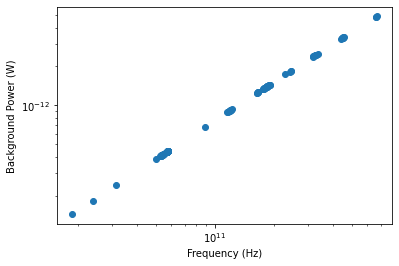

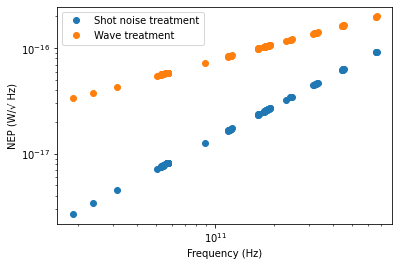

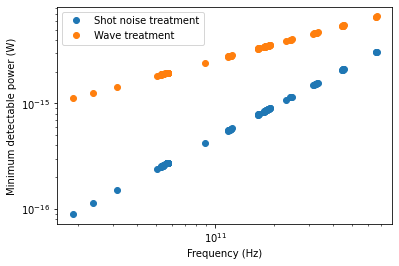

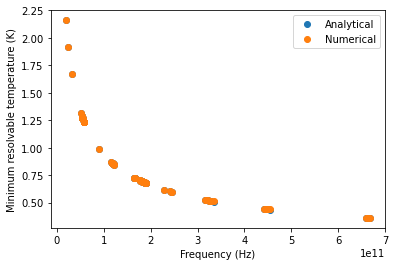

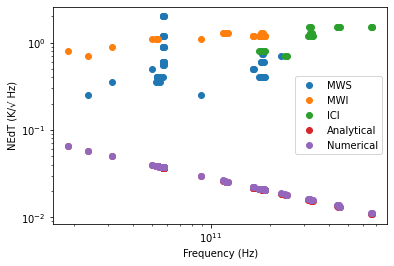

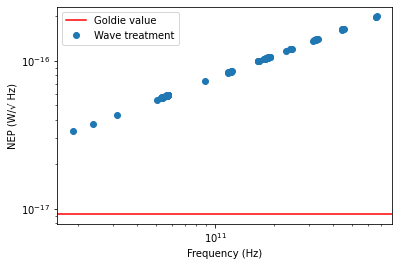

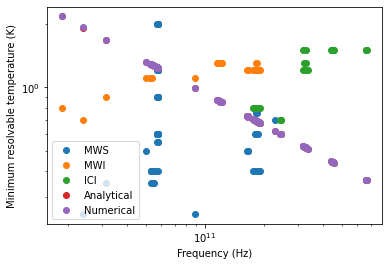

In [36]:
#Plot Results
plt.figure()
plt.loglog(nu_com,Pback_com_con,linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Background Power (W)')

plt.figure()
plt.loglog(nu_com,NEPph_com_con,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_com,NEPradio_com_con,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')

plt.figure()
plt.loglog(nu_com,Pmin_shot_com_con,label='Shot noise treatment',linestyle='none',marker='o')
plt.loglog(nu_com,Pmin_rad_com_con,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum detectable power (W)')

plt.figure()
plt.plot(nu_com,MRTwav_com_con,label='Analytical',linestyle='none',marker='o')
plt.plot(nu_com,num_MRT_com_con,label='Numerical',linestyle='none',marker='o')
plt.legend()
#plt.ylim(0.35,0.45)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')


plt.figure()
#plt.loglog(nucom,NEdT_actual_com,label='MWS, MWI, and ICI',linestyle='none',marker='o')
plt.loglog(nu_MWS,NEdTactual_MWS,label='MWS',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEdTactual_MWI,label='MWI',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTactual_ICI,label='ICI',linestyle='none',marker='o')
plt.loglog(nu_com,NEdTwav_com_con,label='Analytical',linestyle='none',marker='o')
#plt.loglog(nu_MWS,num_NEdT_shot_MWS,label='NEdT numerical - shot noise',linestyle='none',marker='o')
plt.loglog(nu_com,num_NEdT_wav_com_con,label='Numerical',linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEdT (K/\u221A Hz)')
plt.legend(loc='best')

plt.figure()
plt.axhline(y=9.2e-18,label='Goldie value',color='r',linestyle='-')
plt.loglog(nu_com,NEPradio_com_con,label='Wave treatment',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEP (W/\u221A Hz)')




plt.figure()
#plt.loglog(nucom,NEdT_actual_com,label='MWS, MWI, and ICI',linestyle='none',marker='o')
plt.loglog(nu_MWS,NEdTactual_MWS,label='MWS',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEdTactual_MWI,label='MWI',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTactual_ICI,label='ICI',linestyle='none',marker='o')
plt.loglog(nu_com,MRTwav_com_con,label='Analytical',linestyle='none',marker='o')
plt.loglog(nu_com,num_MRT_com_con,label='Numerical',linestyle='none',marker='o')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')

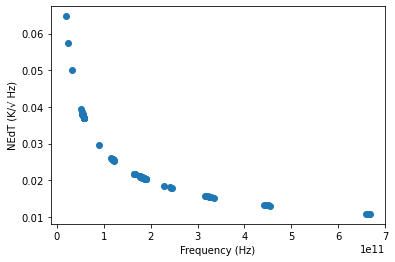

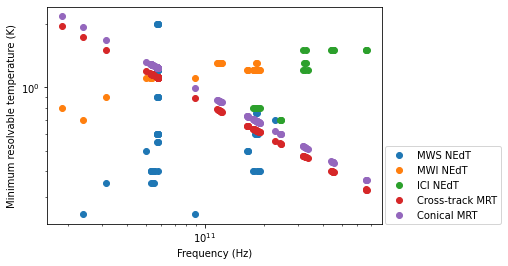

In [37]:
plt.figure()
plt.plot(nu_com,NEdTwav_com_con,label='Conical',linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('NEdT (K/\u221A Hz)')


plt.figure()
plt.loglog(nu_MWS,NEdTactual_MWS,label='MWS NEdT',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEdTactual_MWI,label='MWI NEdT',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTactual_ICI,label='ICI NEdT',linestyle='none',marker='o')
plt.loglog(nu_com,MRTwav_com_cross,label='Cross-track MRT',linestyle='none',marker='o')
plt.loglog(nu_com,MRTwav_com_con,label='Conical MRT',linestyle='none',marker='o')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')
plt.legend(loc=[1.01,0])

In [38]:
print(np.mean(MRTwav_com_con / MRTwav_com_cross))


print(np.mean(NEdTwav_com_con / NEdTwav_com_cross))

1.1100758972350633
1.0


In [39]:
int_time_com_con

0.000448935816752654

In [40]:
print(np.max(nucom)) #668.2 GHz
print(np.min(nucom)) #18.7GHz

print(np.min(foorprint_com_cross))
print(np.max(foorprint_com_cross))

print(np.max(foorprint_com_cross)/np.min(foorprint_com_cross))

print(np.max(nu_MWS))

print(MRTwav_com_cross/MRTwav_com_con *100)


668200000000.0
18700000000.0
1298.9275494931499
46450.39881798062
35.76057712849794
229000000000.0
[90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052 90.08393052
 90.08393052 90.08393052 

# Adjusted integration time

In [41]:
orbit_h_com_adj = 830000 #m

swath_com_adj = 2100000 #m

ap_com_adj = 0.35 #m

#functions
foorprint_com_adj = footprint_crosstrack(ap_com_adj,nu_com,orbit_h_com_adj) 
Aomega_com_adj = Aomega1(nu_com) 

vcom_adj, vcomground_adj = orbit_vels(orbit_h_com_adj)

int_time_com_adj = int_time(foorprint_com_adj,0.9,vcomground_adj,swath_com_adj,calT_com)  
int_time_com_adj = int_time_com_adj[nu_com==2.2900000e+11] # int time for 229GHz

Pback_com_adj = Pback(nu_com,dnu_com,Tback_com,Opt_Eff,Aomega_com_adj)

NEPph_com_adj = NEPph(Pback_com_adj,nu_com)

NEPradio_com_adj = NEPradio(dnu_com,Tback_com)

Pmin_shot_com_adj = Pmin_shot(NEPph_com_adj,int_time_com_adj)

Pmin_rad_com_adj = Pmin_rad(dnu_com,Tback_com,int_time_com_adj)

MRTwav_com_adj = MRTwav(Tback_com,int_time_com_adj,dnu_com)

NEdTwav_com_adj = MRTwav(Tback_com,0.5,dnu_com) #Set int_time to 0.5s to find NEdT

#integration from MWS plan 

int_time_com_adjMWS = 1.3 / 95

Pback_com_adjMWS = Pback(nu_com,dnu_com,Tback_com,Opt_Eff,Aomega_com_adj)

NEPph_com_adjMWS = NEPph(Pback_com_adjMWS,nu_com)

NEPradio_com_adjMWS = NEPradio(dnu_com,Tback_com)

Pmin_shot_com_adjMWS = Pmin_shot(NEPph_com_adjMWS,int_time_com_adjMWS)

Pmin_rad_com_adjMWS = Pmin_rad(dnu_com,Tback_com,int_time_com_adjMWS)

MRTwav_com_adjMWS = MRTwav(Tback_com,int_time_com_adjMWS,dnu_com)

NEdTwav_com_adjMWS = MRTwav(Tback_com,0.5,dnu_com) #Set int_time to 0.5s to find NEdT

Text(0, 0.5, 'Minimum resolvable temperature (K)')

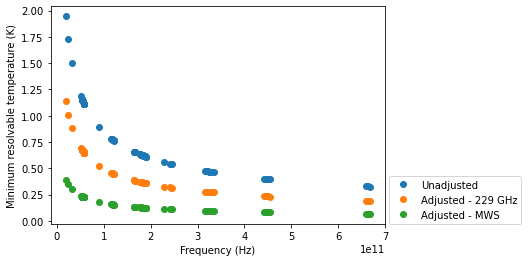

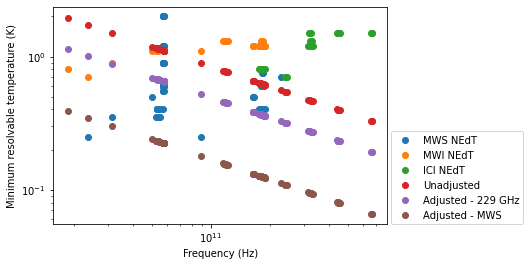

In [43]:
plt.figure()
plt.plot(nu_com,MRTwav_com_cross,label='Unadjusted',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_adj,label='Adjusted - 229 GHz',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_adjMWS,label='Adjusted - MWS',linestyle='none',marker='o')
plt.legend(loc=[1.01,0])
#plt.ylim(0.35,0.45)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')

plt.figure()
plt.loglog(nu_MWS,NEdTactual_MWS,label='MWS NEdT',linestyle='none',marker='o')
plt.loglog(nu_MWI,NEdTactual_MWI,label='MWI NEdT',linestyle='none',marker='o')
plt.loglog(nu_ICI,NEdTactual_ICI,label='ICI NEdT',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_cross,label='Unadjusted',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_adj,label='Adjusted - 229 GHz',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_adjMWS,label='Adjusted - MWS',linestyle='none',marker='o')
plt.legend(loc=[1.01,0])
#plt.ylim(0.35,0.45)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')


# Adjust resolution

In [44]:
res = np.array([100,250,500,1000])

#dnu_res = bandwidth(nu_com,res)

dnu_res = np.zeros([4,107])
for i in range(len(res)):
    dnu_res[i,:] = bandwidth(nu_com,res[i])


orbit_h_com_res = 830000 #m

swath_com_res = 2100000 #m

ap_com_res = 0.35 #m

#functions
foorprint_com_res = footprint_crosstrack(ap_com_res,nu_com,orbit_h_com_res) 

Aomega_com_res = Aomega1(nu_com) 

vcom_res, vcomground_res = orbit_vels(orbit_h_com_res)

int_time_com_res = int_time(foorprint_com_res,0.9,vcomground_res,swath_com_res,calT_com)  
int_time_com_res = np.min(int_time_com_res) # Take the smallest int time and set for all observations

#Pback_com_res = Pback(nu_com,dnu_res,Tback_com,Opt_Eff,Aomega_com_res)

Pback_com_res = np.zeros([4,107])
for i in range(len(res)):
    Pback_com_res[i,:] = Pback(nu_com,dnu_res[i,:],Tback_com,Opt_Eff,Aomega_com_res)

NEPph_com_res = NEPph(Pback_com_res,nu_com)

NEPradio_com_res = NEPradio(dnu_res,Tback_com)

Pmin_shot_com_res = Pmin_shot(NEPph_com_res,int_time_com_res)

Pmin_rad_com_res = Pmin_rad(dnu_res,Tback_com,int_time_com_res)

MRTwav_com_res = MRTwav(Tback_com,int_time_com_cross,dnu_res)

NEdTwav_com_res = MRTwav(Tback_com,0.5,dnu_res)


Text(0, 0.5, 'Minimum resolvable temperature (K)')

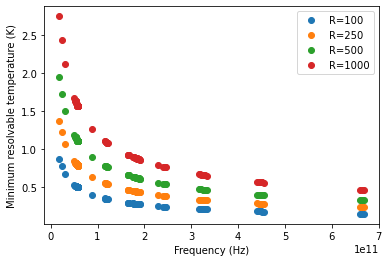

In [45]:
plt.figure()
plt.plot(nu_com,MRTwav_com_res[0,:],label='R=100',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_res[1,:],label='R=250',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_res[2,:],label='R=500',linestyle='none',marker='o')
plt.plot(nu_com,MRTwav_com_res[3,:],label='R=1000',linestyle='none',marker='o')
plt.legend(loc='best')
#plt.ylim(0.35,0.45)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Minimum resolvable temperature (K)')